# Parameter estimation model

We have a basic Groundwater model with three zones Z1, Z2, Z3 where kf-values can differ between 3 and 15 m/d.  
Also we have 18 head observation wells on the following positions and observed values:

In [2]:
Z1_hk = 15  # 3<Z1_hk<15
Z2_hk = 15  # 3<Z2_hk<15
Z3_hk = 3   # 3<Z3_hk<15

hobs = [
    [0, 20, 10, 69.52],
    [0, 40, 10, 71.44],
    [0, 60, 10, 72.99],
    [0, 80, 10, 73.86],
    [0, 20, 45, 58.73],
    [0, 40, 45, 50.57],
    [0, 60, 45, 54.31],
    [0, 80, 45, 58.06],
    [0, 20, 80, 56.31],
    [0, 40, 80, 52.32],
    [0, 60, 80, 46.35],
    [0, 80, 80, 29.01],
    [0, 20, 100, 57.24],
    [0, 40, 100, 54.24],
    [0, 60, 100, 39.48],
    [0, 80, 100, 48.47],    
]

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy.modflow as mf
import flopy.utils as fu
import shutil
import json

%matplotlib inline

In [4]:
model_path = os.path.join('model')

In [5]:
if os.path.exists(model_path):
    shutil.rmtree(model_path)

### Setup mf-package

In [6]:
modelname = 'parEstMod'
ml = mf.Modflow(modelname=modelname, exe_name='mf2005', version='mf2005', model_ws=model_path)

### Setup dis-package

In [7]:
nlay = 1
nrow = 90
ncol = 120

area_width_y = 9000
area_width_x = 12000

delc = area_width_x/ncol
delr = area_width_y/nrow

nper = 1

In [8]:
top = 100
botm = 0

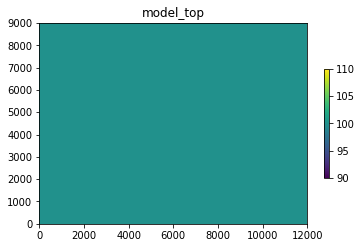

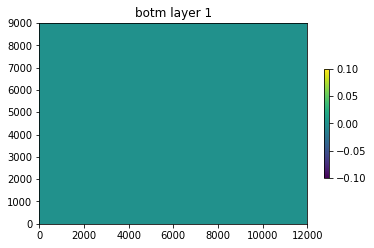

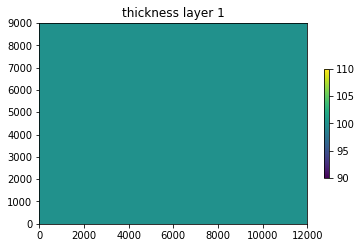

In [9]:
dis = mf.ModflowDis(
    ml, 
    nlay=nlay,
    nrow=nrow, 
    ncol=ncol, 
    delr=delr, 
    delc=delc, 
    top=top, 
    botm=botm, 
    nper=nper, 
    steady=True
)

dis.plot()

### Setup Basic-Package

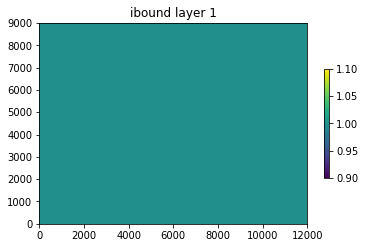

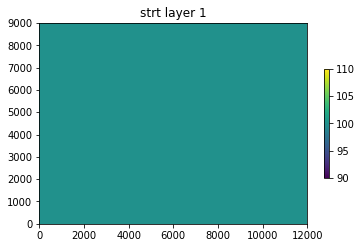

In [10]:
ibound = 1
strt = 100
bas = mf.ModflowBas(ml, ibound=ibound, strt=strt)
bas.plot()

### Setup General Head Boundaries

lets take the start values here and extract the values for each border and layer

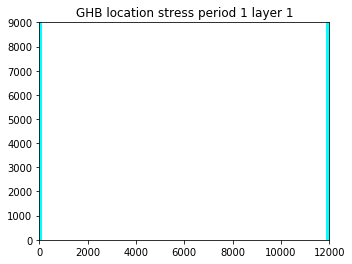

In [11]:
#  [lay, row, col, stage, cond]
mask_arr = np.zeros((nlay, nrow, ncol))
mask_arr[:, :, 0] = 80
mask_arr[:, :, -1] = 60

ghb_spd = {0: []}
for layer_id in range(nlay):
    for row_id in range(nrow):
        for col_id in range(ncol):
            if mask_arr[layer_id][row_id][col_id] > 0:
                ghb_spd[0].append([layer_id, row_id, col_id, mask_arr[layer_id][row_id][col_id], 200])

ghb = mf.ModflowGhb(ml, stress_period_data=ghb_spd)
ghb.plot()

### Setup Recharge

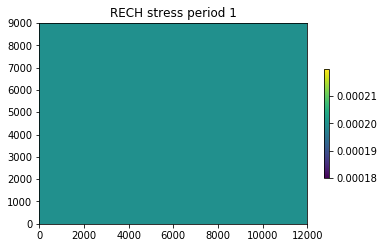

In [12]:
rch = 0.0002
rech = {}
rech[0] = rch
rch = mf.ModflowRch(ml, rech=rech, nrchop = 3)

rch.plot()

### Setup the well boundary

Add wells here. Load from CSV and calculate layer.

In [13]:
welSp = {}
welSp[0] = [
    [0, 20, 20, -20000],
    [0, 40, 40, -20000],
    [0, 60, 60, -20000], 
    [0, 80, 80, -20000],     
    [0, 60, 100, -20000],         
]

wel = mf.ModflowWel(ml, stress_period_data=welSp)

### Setup Flow-Package

In [14]:
hk = np.zeros((nlay, nrow, ncol))
hk[:, :, 0:40] = Z1_hk
hk[:, :, 40:80] = Z2_hk
hk[:, :, 80:120] = Z3_hk

lpf = mf.ModflowLpf(ml, hk=hk, layavg=0, layvka=0, sy=0.3, ipakcb=53)

### Setup Solver Package and Output-control with defaults

In [15]:
pcg = mf.ModflowPcg(ml,rclose=1e-1)
oc = mf.ModflowOc(ml)

In [16]:
ml.write_input()
ml.run_model()

FloPy is using the following  executable to run the model: /usr/local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: parEstMod.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2019/01/29 21:59:33

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2019/01/29 21:59:33
 Elapsed run time:  0.034 Seconds

  Normal termination of simulation


(True, [])

### Read output file

In [17]:
hds = fu.HeadFile(os.path.join(model_path, modelname + '.hds'))
times = hds.get_times()
print(times)

[1.0]


### Plot output file

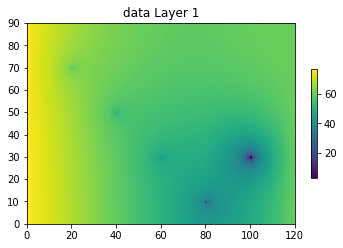

In [17]:
hds.plot(totim=times[-1], colorbar=True, masked_values=[-1e30])

### Calculate the least-square from observed-vs calculated values

In [18]:
sum = 0;

for hob in hobs:
    observed   = hob[3]
    calculated = hds.get_data(totim=times[-1])[hob[0]][hob[1]][hob[2]]
    sum += (observed-calculated) ** 2
    
print(sum)

1449.7161372958833
